<a href="https://colab.research.google.com/github/ecthompsoncodes/FDS-Epi-Project/blob/main/Neural_Network_Epi_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Original Model

In [ ]:
torch.manual_seed(44)
np.random.seed(44)
random.seed(44)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(44)


data = pd.read_csv("data_412.csv")
#data.head()

data['county'], mapping_index = pd.factorize(data['county'])
data['region'], mapping_index = pd.factorize(data['region'])
data['tranlevel'], mapping_index = pd.factorize(data['tranlevel'])
data['tranlevel_in_2_weeks'], mapping_index = pd.factorize(data['tranlevel_in_2_weeks'])
#data = data[['cases', 'county', 'date_number', 'Population', 'region', 'pop_dens', 'crime_per_100k', 'tranlevel','tranlevel_in_2_weeks']]
data = data[['cases', 'county', 'date_number', 'pop_dens','tranlevel_in_2_weeks']]
data.head()
# cases?

,cases,county,date_number,pop_dens,tranlevel_in_2_weeks
0,19035,0,1,404.8,0
1,3908,1,1,107.1,1
2,25979,2,1,1133.7,0
3,18087,3,1,410.4,0
4,8160,4,1,62.4,0


In [ ]:
# e_num = 11

In [ ]:
X = data.iloc[:, :-1]  # all columns except the last one
y = data.iloc[:, -1]


# Split the data into training and temporary datasets (60% training, 40% for temp).
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary datasets into validation and test datasets (50% validation, 50% test of the temp data).
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# X = data.iloc[:, :-1]  # all columns except the last one
# y = data.iloc[:, -1]   # the last column

# # Split the data into training and temporary datasets (60% training, 40% for temp).
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# # Split the temporary datasets into validation and test datasets (50% validation, 50% test of the temp data).
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# convert dataframe to numpy array
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.int64)

X_valid_np = X_val.to_numpy(dtype=np.float32)
y_valid_np = y_val.to_numpy(dtype=np.int64)

X_test_np = X_test.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.int64)

# convert numpy array to PyTorch Tensor
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)

X_valid_tensor = torch.from_numpy(X_valid_np)
y_valid_tensor = torch.from_numpy(y_valid_np)

X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np)

# create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create DataLoaders
batch_size = 32 # 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = 0.2 # before hyperparameter tuning

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam


In [ ]:
# Define a list of dropout rates to explore
dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

# Initialize variables to keep track of the best dropout rate and its performance
best_dropout_rate = None
best_accuracy = 0.0

for dropout_rate in dropout_rates:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current dropout rate
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())  # Labels are still one-hot encoded here
            val_preds.extend(predicted.cpu().numpy())


    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this dropout rate resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_dropout_rate = dropout_rate

# Print the best dropout rate
print("Best Dropout Rate:", best_dropout_rate)

Best Dropout Rate: 0.4


In [ ]:
class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = best_dropout_rate # tuned

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
epochs_list = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Initialize variables to keep track of the best number of epochs and its performance
best_num_epochs = None
best_accuracy = 0.0

for num_epochs in epochs_list:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current number of epochs
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use Adam
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())  # Labels are still one-hot encoded here
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this number of epochs resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_num_epochs = num_epochs

# Print the best number of epochs
print("Best Number of Epochs:", best_num_epochs)


Best Number of Epochs: 4


In [ ]:
num_epochs = best_num_epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # loss = criterion(outputs, labels.float())
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Print average training loss per batch
    print(f"Average Training Loss: {train_loss / train_steps:.4f}")

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # _, predicted = torch.max(outputs.data, 1)
            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate and print validation accuracy
    # val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Predicted value: {np.array(val_preds)}")
    print(f"Actual value: {np.array(val_labels)}")

    # plot prediction
    # function where population density on horizontal and proportion
    # even just showing not linear

df_results = pd.DataFrame({
    'Actual': np.array(val_labels),
    'Predicted': np.array(val_preds)
    })

pd.options.display.max_rows = 4000
print(df_results)


Epoch 1/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 295.82it/s]


Average Training Loss: 201.0117


Epoch 1/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 805.74it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 2/4 - Training: 100%|██████████| 291/291 [00:01<00:00, 278.04it/s]


Average Training Loss: 133.8415


Epoch 2/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1006.63it/s]


Validation Accuracy: 0.7997
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 3/4 - Training: 100%|██████████| 291/291 [00:01<00:00, 253.08it/s]


Average Training Loss: 82.8210


Epoch 3/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 866.20it/s]


Validation Accuracy: 0.7810
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 4/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 303.29it/s]


Average Training Loss: 49.5976


Epoch 4/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1034.35it/s]

Validation Accuracy: 0.8155
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]
      Actual  Predicted
0          2          2
1          1          2
2          2          2
3          2          2
4          2          2
5          2          2
6          2          2
7          2          2
8          2          2
9          2          2
10         2          2
11         2          2
12         2          2
13         2          2
14         2          2
15         2          2
16         2          2
17         2          2
18         2          2
19         2          2
20         2          2
21         2          2
22         2          2
23         2          2
24         2          2
25         2          2
26         2          2
27         2          2
28         2          2
29         2          2
30         0          2
31         2          2
32         2          2
33         2          2
34         1          1
35         2          2
36         2     

Epoch 4/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 890.57it/s]


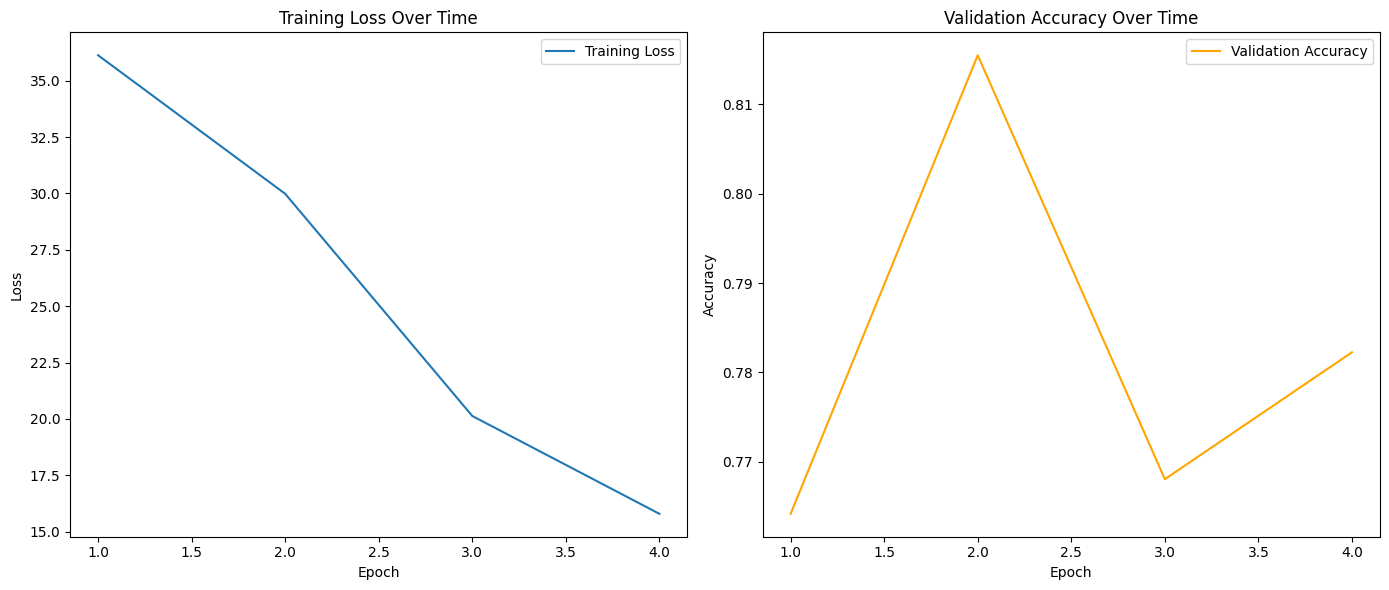

In [ ]:
import matplotlib.pyplot as plt
num_epochs = best_num_epochs
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Average training loss
    train_losses.append(train_loss / train_steps)

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    val_accuracies.append(val_accuracy)

# After training is done, plot the training loss and validation accuracy
plt.figure(figsize=(14, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs.data, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

# Convert one-hot encoded labels to class indices
# val_labels_class_indices = np.argmax(val_labels, axis=1)

# Calculate and print validation accuracy
# val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
og_mod_test_accuracy = np.sum(np.array(test_labels) == np.array(test_preds)) / len(test_preds)
print(f"Validation Accuracy: {og_mod_test_accuracy:.4f}")

100%|██████████| 97/97 [00:00<00:00, 859.69it/s]

Validation Accuracy: 0.7781


Adding Longitude and Latitude

In [ ]:
data = pd.read_csv("data_412.csv")
#data.head()

data['county'], mapping_index = pd.factorize(data['county'])
data['region'], mapping_index = pd.factorize(data['region'])
data['tranlevel'], mapping_index = pd.factorize(data['tranlevel'])
data['tranlevel_in_2_weeks'], mapping_index = pd.factorize(data['tranlevel_in_2_weeks'])
#data = data[['cases', 'county', 'date_number', 'Population', 'region', 'pop_dens', 'crime_per_100k', 'tranlevel','tranlevel_in_2_weeks']]
data = data[['cases', 'county', 'date_number', 'pop_dens', 'Longitude', 'Latitude', 'tranlevel_in_2_weeks']]
data.head()
# cases?

,cases,county,date_number,pop_dens,Longitude,Latitude,tranlevel_in_2_weeks
0,19035,0,1,404.8,-79.399425,36.043710,0
1,3908,1,1,107.1,-79.480429,34.840885,1
2,25979,2,1,1133.7,-78.876593,36.036030,0
3,18087,3,1,410.4,-82.530107,35.611178,0
4,8160,4,1,62.4,-78.371391,34.991536,0


In [ ]:
X = data.iloc[:, :-1]  # all columns except the last one
y = data.iloc[:, -1]


# Split the data into training and temporary datasets (60% training, 40% for temp).
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary datasets into validation and test datasets (50% validation, 50% test of the temp data).
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# convert dataframe to numpy array
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.int64)

X_valid_np = X_val.to_numpy(dtype=np.float32)
y_valid_np = y_val.to_numpy(dtype=np.int64)

X_test_np = X_test.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.int64)

# convert numpy array to PyTorch Tensor
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)

X_valid_tensor = torch.from_numpy(X_valid_np)
y_valid_tensor = torch.from_numpy(y_valid_np)

X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np)

# create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create DataLoaders
batch_size = 32 # 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = 0.2 # before hyperparameter tuning

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam


In [ ]:
# Define a list of dropout rates to explore
dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

# Initialize variables to keep track of the best dropout rate and its performance
best_dropout_rate = None
best_accuracy = 0.0

for dropout_rate in dropout_rates:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current dropout rate
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())  # Labels are still one-hot encoded here
            val_preds.extend(predicted.cpu().numpy())


    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this dropout rate resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_dropout_rate = dropout_rate

# Print the best dropout rate
print("Best Dropout Rate:", best_dropout_rate)

Best Dropout Rate: 0.0


In [ ]:
# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = best_dropout_rate # tuned

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
#epochs_list = [1, 5, 6, 7, 8, 9, 10, 15, 20]

# Initialize variables to keep track of the best number of epochs and its performance
best_num_epochs = None
best_accuracy = 0.0

for num_epochs in epochs_list:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current number of epochs
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use Adam since NLP
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this number of epochs resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_num_epochs = num_epochs

# Print the best number of epochs
print("Best Number of Epochs:", best_num_epochs)


Best Number of Epochs: 12


In [ ]:
num_epochs = best_num_epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # loss = criterion(outputs, labels.float())
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Print average training loss per batch
    print(f"Average Training Loss: {train_loss / train_steps:.4f}")

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # _, predicted = torch.max(outputs.data, 1)
            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate and print validation accuracy
    # val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Predicted value: {np.array(val_preds)}")
    print(f"Actual value: {np.array(val_labels)}")


Epoch 1/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 429.46it/s]


Average Training Loss: 13.5780


Epoch 1/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1018.61it/s]


Validation Accuracy: 0.5545
Predicted value: [2 1 1 ... 2 1 1]
Actual value: [2 1 2 ... 2 2 2]


Epoch 2/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 332.96it/s]


Average Training Loss: 14.9425


Epoch 2/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1208.00it/s]


Validation Accuracy: 0.7539
Predicted value: [2 2 2 ... 2 0 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 3/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 341.21it/s]


Average Training Loss: 11.0952


Epoch 3/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1135.53it/s]


Validation Accuracy: 0.7771
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 4/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 358.43it/s]


Average Training Loss: 10.7385


Epoch 4/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1139.46it/s]


Validation Accuracy: 0.7894
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 5/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 325.41it/s]


Average Training Loss: 10.5385


Epoch 5/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 859.29it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 6/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 430.92it/s]


Average Training Loss: 8.4847


Epoch 6/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1716.87it/s]


Validation Accuracy: 0.7619
Predicted value: [2 2 2 ... 2 0 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 7/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 493.57it/s]


Average Training Loss: 9.8229


Epoch 7/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1659.15it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 8/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 521.48it/s]


Average Training Loss: 11.4419


Epoch 8/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1320.54it/s]


Validation Accuracy: 0.8077
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 9/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 432.20it/s]


Average Training Loss: 10.7138


Epoch 9/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1449.20it/s]


Validation Accuracy: 0.8145
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 10/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 461.52it/s]


Average Training Loss: 8.6766


Epoch 10/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1385.92it/s]


Validation Accuracy: 0.3932
Predicted value: [2 0 2 ... 0 0 0]
Actual value: [2 1 2 ... 2 2 2]


Epoch 11/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 479.35it/s]


Average Training Loss: 10.8250


Epoch 11/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1508.19it/s]


Validation Accuracy: 0.8113
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 12/12 - Training: 100%|██████████| 291/291 [00:00<00:00, 531.10it/s]


Average Training Loss: 8.6354


Epoch 12/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1509.48it/s]

Validation Accuracy: 0.1416
Predicted value: [1 1 1 ... 1 1 1]
Actual value: [2 1 2 ... 2 2 2]


Epoch 12/12 - Validation: 100%|██████████| 97/97 [00:00<00:00, 978.36it/s]


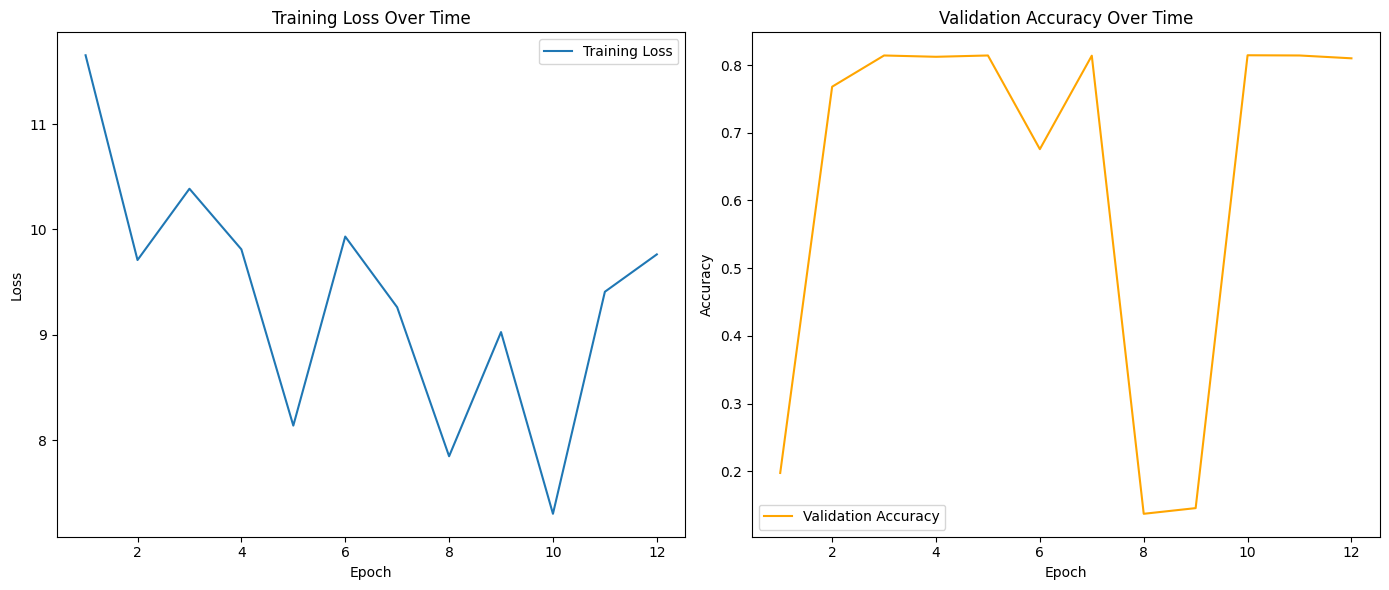

In [ ]:
num_epochs = best_num_epochs
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Average training loss
    train_losses.append(train_loss / train_steps)

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    val_accuracies.append(val_accuracy)

# After training is done, plot the training loss and validation accuracy
plt.figure(figsize=(14, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs.data, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

# Convert one-hot encoded labels to class indices
# val_labels_class_indices = np.argmax(val_labels, axis=1)

# Calculate and print validation accuracy
# val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
ll_test_accuracy = np.sum(np.array(test_labels) == np.array(test_preds)) / len(test_preds)
print(f"Validation Accuracy: {ll_test_accuracy:.4f}")

100%|██████████| 97/97 [00:00<00:00, 1452.03it/s]

Validation Accuracy: 0.8300


Try original without date

In [ ]:
data = pd.read_csv("data_412.csv")
#data.head()

data['county'], mapping_index = pd.factorize(data['county'])
data['region'], mapping_index = pd.factorize(data['region'])
data['tranlevel'], mapping_index = pd.factorize(data['tranlevel'])
data['tranlevel_in_2_weeks'], mapping_index = pd.factorize(data['tranlevel_in_2_weeks'])
#data = data[['cases', 'county', 'date_number', 'Population', 'region', 'pop_dens', 'crime_per_100k', 'tranlevel','tranlevel_in_2_weeks']]
data = data[['cases', 'county', 'pop_dens', 'tranlevel_in_2_weeks']]
data.head()

,cases,county,pop_dens,tranlevel_in_2_weeks
0,19035,0,404.8,0
1,3908,1,107.1,1
2,25979,2,1133.7,0
3,18087,3,410.4,0
4,8160,4,62.4,0


In [ ]:
X = data.iloc[:, :-1]  # all columns except the last one
y = data.iloc[:, -1]


# Split the data into training and temporary datasets (60% training, 40% for temp).
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary datasets into validation and test datasets (50% validation, 50% test of the temp data).
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# convert dataframe to numpy array
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.int64)

X_valid_np = X_val.to_numpy(dtype=np.float32)
y_valid_np = y_val.to_numpy(dtype=np.int64)

X_test_np = X_test.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.int64)

# convert numpy array to PyTorch Tensor
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)

X_valid_tensor = torch.from_numpy(X_valid_np)
y_valid_tensor = torch.from_numpy(y_valid_np)

X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np)

# create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create DataLoaders
batch_size = 32 # 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = 0.2 # before hyperparameter tuning

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
 # Define a list of dropout rates to explore
dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

# Initialize variables to keep track of the best dropout rate and its performance
best_dropout_rate = None
best_accuracy = 0.0

for dropout_rate in dropout_rates:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current dropout rate
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())  # Labels are still one-hot encoded here
            val_preds.extend(predicted.cpu().numpy())


    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this dropout rate resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_dropout_rate = dropout_rate

# Print the best dropout rate
print("Best Dropout Rate:", best_dropout_rate)

Best Dropout Rate: 0.2


In [ ]:
# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = best_dropout_rate # tuned

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
# epochs_list = [1, 5, 6, 7, 8, 9, 10, 15, 20]

# Initialize variables to keep track of the best number of epochs and its performance
best_num_epochs = None
best_accuracy = 0.0

for num_epochs in epochs_list:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current number of epochs
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use Adam since NLP
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this number of epochs resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_num_epochs = num_epochs

# Print the best number of epochs
print("Best Number of Epochs:", best_num_epochs)

Best Number of Epochs: 4


In [ ]:
num_epochs = best_num_epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # loss = criterion(outputs, labels.float())
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Print average training loss per batch
    print(f"Average Training Loss: {train_loss / train_steps:.4f}")

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # _, predicted = torch.max(outputs.data, 1)
            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate and print validation accuracy
    # val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Predicted value: {np.array(val_preds)}")
    print(f"Actual value: {np.array(val_labels)}")


Epoch 1/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 508.72it/s]


Average Training Loss: 81.4973


Epoch 1/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1413.49it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 2/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 490.14it/s]


Average Training Loss: 55.8327


Epoch 2/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1623.66it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 3/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 453.05it/s]


Average Training Loss: 35.1830


Epoch 3/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1791.70it/s]


Validation Accuracy: 0.7784
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 4/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 478.27it/s]


Average Training Loss: 23.0165


Epoch 4/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1486.16it/s]

Validation Accuracy: 0.7713
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 4/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1547.14it/s]


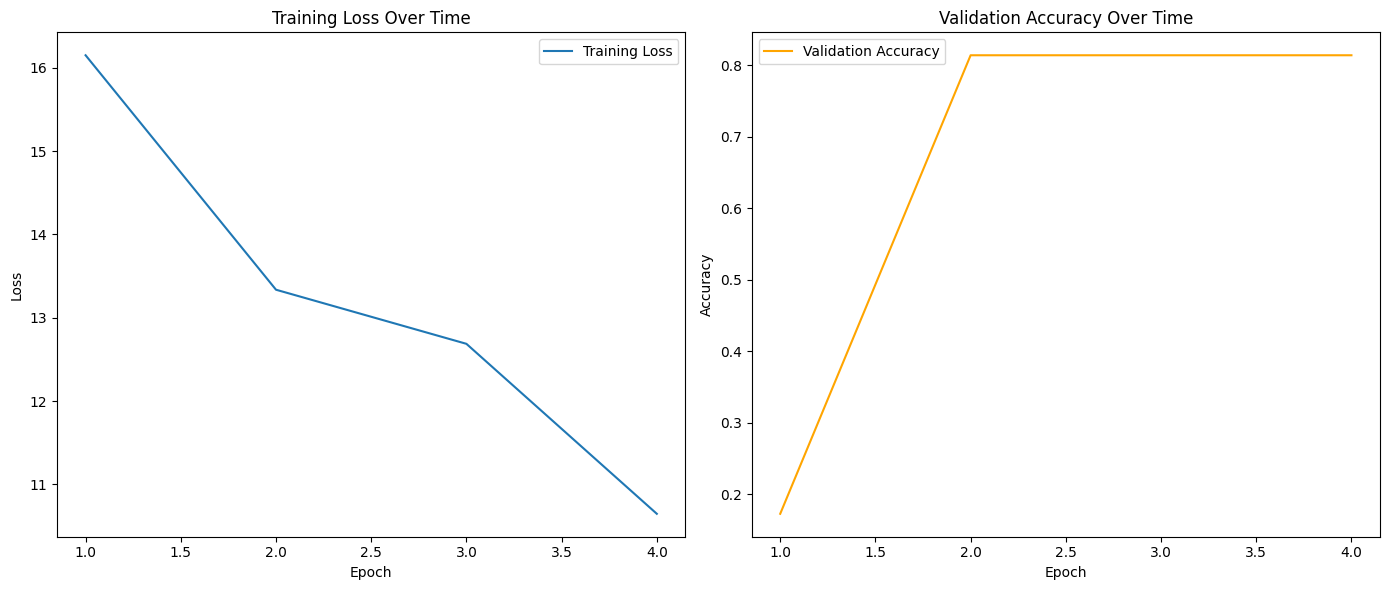

In [ ]:
import matplotlib.pyplot as plt
num_epochs = best_num_epochs
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Average training loss
    train_losses.append(train_loss / train_steps)

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    val_accuracies.append(val_accuracy)

# After training is done, plot the training loss and validation accuracy
plt.figure(figsize=(14, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs.data, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

# Convert one-hot encoded labels to class indices
# val_labels_class_indices = np.argmax(val_labels, axis=1)

# Calculate and print validation accuracy
# val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
og_no_date_test_accuracy = np.sum(np.array(test_labels) == np.array(test_preds)) / len(test_preds)
print(f"Validation Accuracy: {og_no_date_test_accuracy:.4f}")

100%|██████████| 97/97 [00:00<00:00, 1420.62it/s]

Validation Accuracy: 0.8329


Try just cases

In [ ]:
data = pd.read_csv("data_412.csv")
#data.head()

data['county'], mapping_index = pd.factorize(data['county'])
data['region'], mapping_index = pd.factorize(data['region'])
data['tranlevel'], mapping_index = pd.factorize(data['tranlevel'])
data['tranlevel_in_2_weeks'], mapping_index = pd.factorize(data['tranlevel_in_2_weeks'])
#data = data[['cases', 'county', 'date_number', 'Population', 'region', 'pop_dens', 'crime_per_100k', 'tranlevel','tranlevel_in_2_weeks']]
data = data[['cases',
             #'date_number',
             #'pop_dens',
             'tranlevel_in_2_weeks']]
data.head()

,cases,tranlevel_in_2_weeks
0,19035,0
1,3908,1
2,25979,0
3,18087,0
4,8160,0


In [ ]:
X = data.iloc[:, :-1]  # all columns except the last one
y = data.iloc[:, -1]


# Split the data into training and temporary datasets (60% training, 40% for temp).
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary datasets into validation and test datasets (50% validation, 50% test of the temp data).
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# convert dataframe to numpy array
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.int64)

X_valid_np = X_val.to_numpy(dtype=np.float32)
y_valid_np = y_val.to_numpy(dtype=np.int64)

X_test_np = X_test.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.int64)

# convert numpy array to PyTorch Tensor
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)

X_valid_tensor = torch.from_numpy(X_valid_np)
y_valid_tensor = torch.from_numpy(y_valid_np)

X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np)

# create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create DataLoaders
batch_size = 32 # 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = 0.2 # before hyperparameter tuning

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
# Define a list of dropout rates to explore
dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

# Initialize variables to keep track of the best dropout rate and its performance
best_dropout_rate = None
best_accuracy = 0.0

for dropout_rate in dropout_rates:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current dropout rate
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())  # Labels are still one-hot encoded here
            val_preds.extend(predicted.cpu().numpy())


    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this dropout rate resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_dropout_rate = dropout_rate

# Print the best dropout rate
print("Best Dropout Rate:", best_dropout_rate)

Best Dropout Rate: 0.0


In [ ]:
# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = best_dropout_rate # tuned

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
# epochs_list = [1, 5, 6, 7, 8, 9, 10, 15, 20]

# Initialize variables to keep track of the best number of epochs and its performance
best_num_epochs = None
best_accuracy = 0.0

for num_epochs in epochs_list:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current number of epochs
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use Adam since NLP
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this number of epochs resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_num_epochs = num_epochs

# Print the best number of epochs
print("Best Number of Epochs:", best_num_epochs)

Best Number of Epochs: 9


In [ ]:
num_epochs = best_num_epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # loss = criterion(outputs, labels.float())
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Print average training loss per batch
    print(f"Average Training Loss: {train_loss / train_steps:.4f}")

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # _, predicted = torch.max(outputs.data, 1)
            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate and print validation accuracy
    # val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Predicted value: {np.array(val_preds)}")
    print(f"Actual value: {np.array(val_labels)}")

Epoch 1/9 - Training: 100%|██████████| 291/291 [00:00<00:00, 530.61it/s]


Average Training Loss: 1503.6654


Epoch 1/9 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1659.22it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 2/9 - Training: 100%|██████████| 291/291 [00:00<00:00, 516.43it/s]


Average Training Loss: 299.7095


Epoch 2/9 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1412.66it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 3/9 - Training: 100%|██████████| 291/291 [00:00<00:00, 511.04it/s]


Average Training Loss: 77.9704


Epoch 3/9 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1663.81it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 4/9 - Training: 100%|██████████| 291/291 [00:00<00:00, 368.34it/s]


Average Training Loss: 36.8124


Epoch 4/9 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1234.70it/s]


Validation Accuracy: 0.6597
Predicted value: [2 1 2 ... 2 2 1]
Actual value: [2 1 2 ... 2 2 2]


Epoch 5/9 - Training: 100%|██████████| 291/291 [00:00<00:00, 349.33it/s]


Average Training Loss: 12.1756


Epoch 5/9 - Validation: 100%|██████████| 97/97 [00:00<00:00, 987.11it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 6/9 - Training: 100%|██████████| 291/291 [00:00<00:00, 339.96it/s]


Average Training Loss: 13.1248


Epoch 6/9 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1031.46it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 7/9 - Training: 100%|██████████| 291/291 [00:00<00:00, 334.78it/s]


Average Training Loss: 17.6041


Epoch 7/9 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1077.48it/s]


Validation Accuracy: 0.1145
Predicted value: [0 1 1 ... 1 1 1]
Actual value: [2 1 2 ... 2 2 2]


Epoch 8/9 - Training: 100%|██████████| 291/291 [00:00<00:00, 407.46it/s]


Average Training Loss: 10.8793


Epoch 8/9 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1692.86it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 9/9 - Training: 100%|██████████| 291/291 [00:00<00:00, 520.88it/s]


Average Training Loss: 15.2828


Epoch 9/9 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1511.30it/s]

Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 9/9 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1605.67it/s]


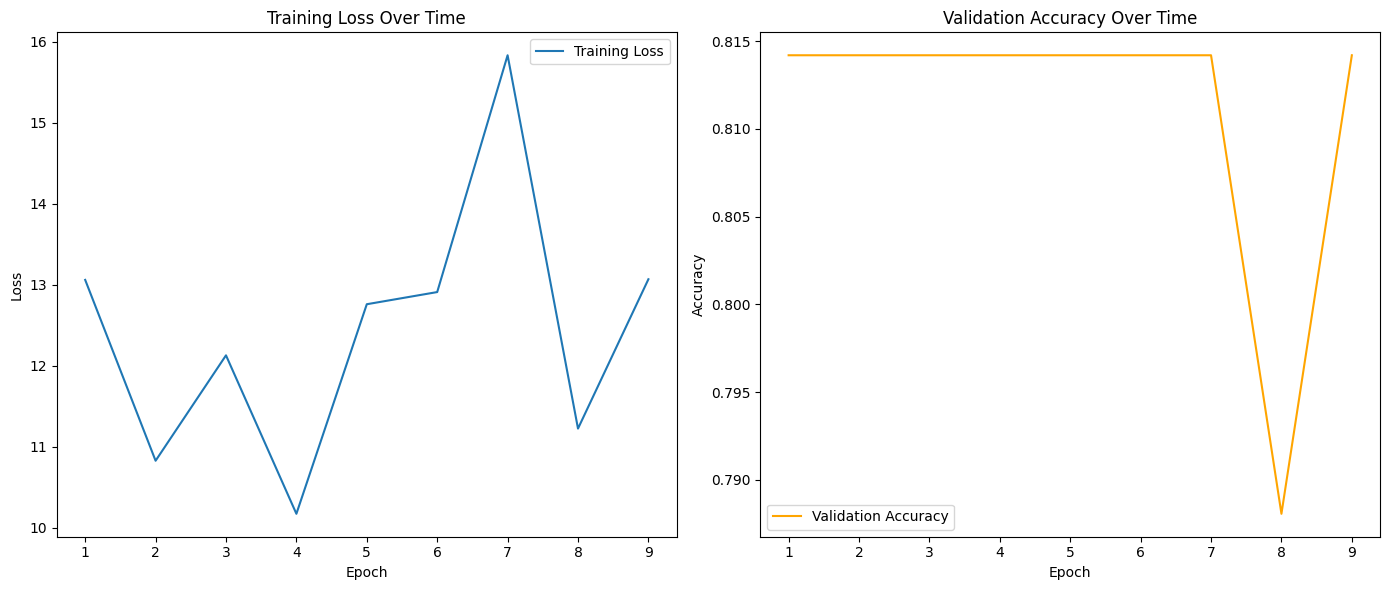

In [ ]:
num_epochs = best_num_epochs
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Average training loss
    train_losses.append(train_loss / train_steps)

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    val_accuracies.append(val_accuracy)

# After training is done, plot the training loss and validation accuracy
plt.figure(figsize=(14, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs.data, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

# Convert one-hot encoded labels to class indices
# val_labels_class_indices = np.argmax(val_labels, axis=1)

# Calculate and print validation accuracy
# val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
cases_accuracy = np.sum(np.array(test_labels) == np.array(test_preds)) / len(test_preds)
print(f"Validation Accuracy: {cases_accuracy:.4f}")

100%|██████████| 97/97 [00:00<00:00, 1460.07it/s]

Validation Accuracy: 0.8329


Try original without county

In [ ]:
data = pd.read_csv("data_412.csv")
#data.head()

data['county'], mapping_index = pd.factorize(data['county'])
data['region'], mapping_index = pd.factorize(data['region'])
data['tranlevel'], mapping_index = pd.factorize(data['tranlevel'])
data['tranlevel_in_2_weeks'], mapping_index = pd.factorize(data['tranlevel_in_2_weeks'])
#data = data[['cases', 'county', 'date_number', 'Population', 'region', 'pop_dens', 'crime_per_100k', 'tranlevel','tranlevel_in_2_weeks']]
data = data[['cases',
             'date_number',
             'pop_dens',
             'tranlevel_in_2_weeks']]
data.head()

,cases,date_number,pop_dens,tranlevel_in_2_weeks
0,19035,1,404.8,0
1,3908,1,107.1,1
2,25979,1,1133.7,0
3,18087,1,410.4,0
4,8160,1,62.4,0


In [ ]:
# Define a list of dropout rates to explore
dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

# Initialize variables to keep track of the best dropout rate and its performance
best_dropout_rate = None
best_accuracy = 0.0

for dropout_rate in dropout_rates:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current dropout rate
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())  # Labels are still one-hot encoded here
            val_preds.extend(predicted.cpu().numpy())


    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this dropout rate resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_dropout_rate = dropout_rate

# Print the best dropout rate
print("Best Dropout Rate:", best_dropout_rate)

Best Dropout Rate: 0.0


In [ ]:
X = data.iloc[:, :-1]  # all columns except the last one
y = data.iloc[:, -1]


# Split the data into training and temporary datasets (60% training, 40% for temp).
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary datasets into validation and test datasets (50% validation, 50% test of the temp data).
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# convert dataframe to numpy array
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.int64)

X_valid_np = X_val.to_numpy(dtype=np.float32)
y_valid_np = y_val.to_numpy(dtype=np.int64)

X_test_np = X_test.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.int64)

# convert numpy array to PyTorch Tensor
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)

X_valid_tensor = torch.from_numpy(X_valid_np)
y_valid_tensor = torch.from_numpy(y_valid_np)

X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np)

# create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create DataLoaders
batch_size = 32 # 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = 0.2 # before hyperparameter tuning

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
 # Define a list of dropout rates to explore
dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

# Initialize variables to keep track of the best dropout rate and its performance
best_dropout_rate = None
best_accuracy = 0.0

for dropout_rate in dropout_rates:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current dropout rate
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())  # Labels are still one-hot encoded here
            val_preds.extend(predicted.cpu().numpy())


    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this dropout rate resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_dropout_rate = dropout_rate

# Print the best dropout rate
print("Best Dropout Rate:", best_dropout_rate)

Best Dropout Rate: 0.0


In [ ]:
# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = best_dropout_rate # tuned

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
# epochs_list = [1, 5, 6, 7, 8, 9, 10, 15, 20]

# Initialize variables to keep track of the best number of epochs and its performance
best_num_epochs = None
best_accuracy = 0.0

for num_epochs in epochs_list:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current number of epochs
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use Adam since NLP
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this number of epochs resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_num_epochs = num_epochs

# Print the best number of epochs
print("Best Number of Epochs:", best_num_epochs)

Best Number of Epochs: 4


In [ ]:
num_epochs = best_num_epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # loss = criterion(outputs, labels.float())
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Print average training loss per batch
    print(f"Average Training Loss: {train_loss / train_steps:.4f}")

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # _, predicted = torch.max(outputs.data, 1)
            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate and print validation accuracy
    # val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Predicted value: {np.array(val_preds)}")
    print(f"Actual value: {np.array(val_labels)}")

Epoch 1/4 - Training: 100%|██████████| 291/291 [00:01<00:00, 262.11it/s]


Average Training Loss: 244.5989


Epoch 1/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 957.61it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 2/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 425.17it/s]


Average Training Loss: 83.3780


Epoch 2/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1580.08it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 3/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 448.44it/s]


Average Training Loss: 35.2146


Epoch 3/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1475.29it/s]


Validation Accuracy: 0.8142
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 4/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 468.31it/s]


Average Training Loss: 23.2165


Epoch 4/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1462.95it/s]

Validation Accuracy: 0.8145
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 4/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1673.56it/s]


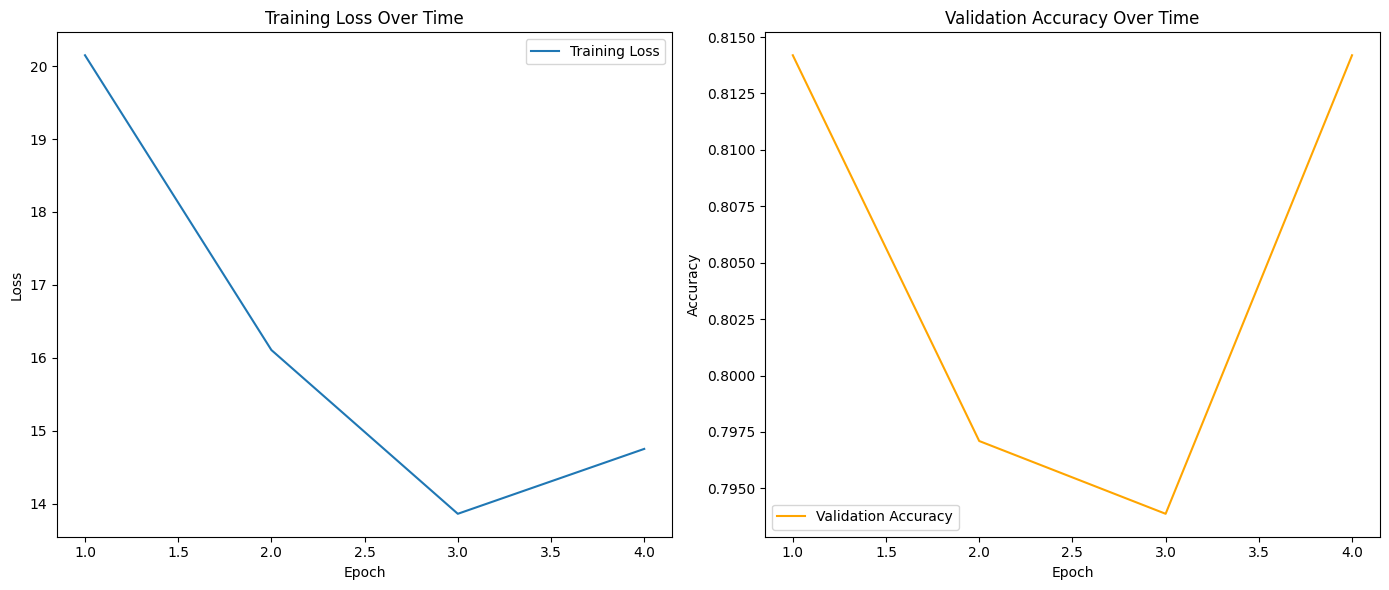

In [ ]:
import matplotlib.pyplot as plt
num_epochs = best_num_epochs
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Average training loss
    train_losses.append(train_loss / train_steps)

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    val_accuracies.append(val_accuracy)

# After training is done, plot the training loss and validation accuracy
plt.figure(figsize=(14, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs.data, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

# Convert one-hot encoded labels to class indices
# val_labels_class_indices = np.argmax(val_labels, axis=1)

# Calculate and print validation accuracy
# val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
og_no_county_test_accuracy = np.sum(np.array(test_labels) == np.array(test_preds)) / len(test_preds)
print(f"Validation Accuracy: {og_no_county_test_accuracy:.4f}")

100%|██████████| 97/97 [00:00<00:00, 1267.40it/s]

Validation Accuracy: 0.8329


Remove county in lat/long model

In [ ]:
data = pd.read_csv("data_412.csv")
#data.head()

data['county'], mapping_index = pd.factorize(data['county'])
data['region'], mapping_index = pd.factorize(data['region'])
data['tranlevel'], mapping_index = pd.factorize(data['tranlevel'])
data['tranlevel_in_2_weeks'], mapping_index = pd.factorize(data['tranlevel_in_2_weeks'])
#data = data[['cases', 'county', 'date_number', 'Population', 'region', 'pop_dens', 'crime_per_100k', 'tranlevel','tranlevel_in_2_weeks']]
data = data[['cases', 'date_number', 'pop_dens', 'Latitude', 'Longitude', 'tranlevel_in_2_weeks']]
data.head()

,cases,date_number,pop_dens,Latitude,Longitude,tranlevel_in_2_weeks
0,19035,1,404.8,36.043710,-79.399425,0
1,3908,1,107.1,34.840885,-79.480429,1
2,25979,1,1133.7,36.036030,-78.876593,0
3,18087,1,410.4,35.611178,-82.530107,0
4,8160,1,62.4,34.991536,-78.371391,0


In [ ]:
X = data.iloc[:, :-1]  # all columns except the last one
y = data.iloc[:, -1]


# Split the data into training and temporary datasets (60% training, 40% for temp).
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary datasets into validation and test datasets (50% validation, 50% test of the temp data).
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# convert dataframe to numpy array
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.int64)

X_valid_np = X_val.to_numpy(dtype=np.float32)
y_valid_np = y_val.to_numpy(dtype=np.int64)

X_test_np = X_test.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.int64)

# convert numpy array to PyTorch Tensor
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)

X_valid_tensor = torch.from_numpy(X_valid_np)
y_valid_tensor = torch.from_numpy(y_valid_np)

X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np)

# create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create DataLoaders
batch_size = 32 # 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = 0.2 # before hyperparameter tuning

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
# Define a list of dropout rates to explore
dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

# Initialize variables to keep track of the best dropout rate and its performance
best_dropout_rate = None
best_accuracy = 0.0

for dropout_rate in dropout_rates:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current dropout rate
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())  # Labels are still one-hot encoded here
            val_preds.extend(predicted.cpu().numpy())


    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this dropout rate resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_dropout_rate = dropout_rate

# Print the best dropout rate
print("Best Dropout Rate:", best_dropout_rate)

Best Dropout Rate: 0.4


In [ ]:
# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = best_dropout_rate # tuned
model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
# epochs_list = [1, 5, 6, 7, 8, 9, 10, 15, 20]

# Initialize variables to keep track of the best number of epochs and its performance
best_num_epochs = None
best_accuracy = 0.0

for num_epochs in epochs_list:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current number of epochs
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use Adam since NLP
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this number of epochs resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_num_epochs = num_epochs

# Print the best number of epochs
print("Best Number of Epochs:", best_num_epochs)

Best Number of Epochs: 4


In [ ]:
num_epochs = best_num_epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # loss = criterion(outputs, labels.float())
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Print average training loss per batch
    print(f"Average Training Loss: {train_loss / train_steps:.4f}")

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # _, predicted = torch.max(outputs.data, 1)
            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate and print validation accuracy
    # val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Predicted value: {np.array(val_preds)}")
    print(f"Actual value: {np.array(val_labels)}")

Epoch 1/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 445.22it/s]


Average Training Loss: 171.7217


Epoch 1/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1550.56it/s]


Validation Accuracy: 0.8100
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 2/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 483.81it/s]


Average Training Loss: 66.5832


Epoch 2/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1403.36it/s]


Validation Accuracy: 0.8016
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 3/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 490.78it/s]


Average Training Loss: 31.1473


Epoch 3/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1383.48it/s]


Validation Accuracy: 0.7832
Predicted value: [2 2 2 ... 2 1 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 4/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 455.83it/s]


Average Training Loss: 21.0664


Epoch 4/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1474.12it/s]

Validation Accuracy: 0.7652
Predicted value: [2 2 2 ... 2 1 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 4/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 989.91it/s]


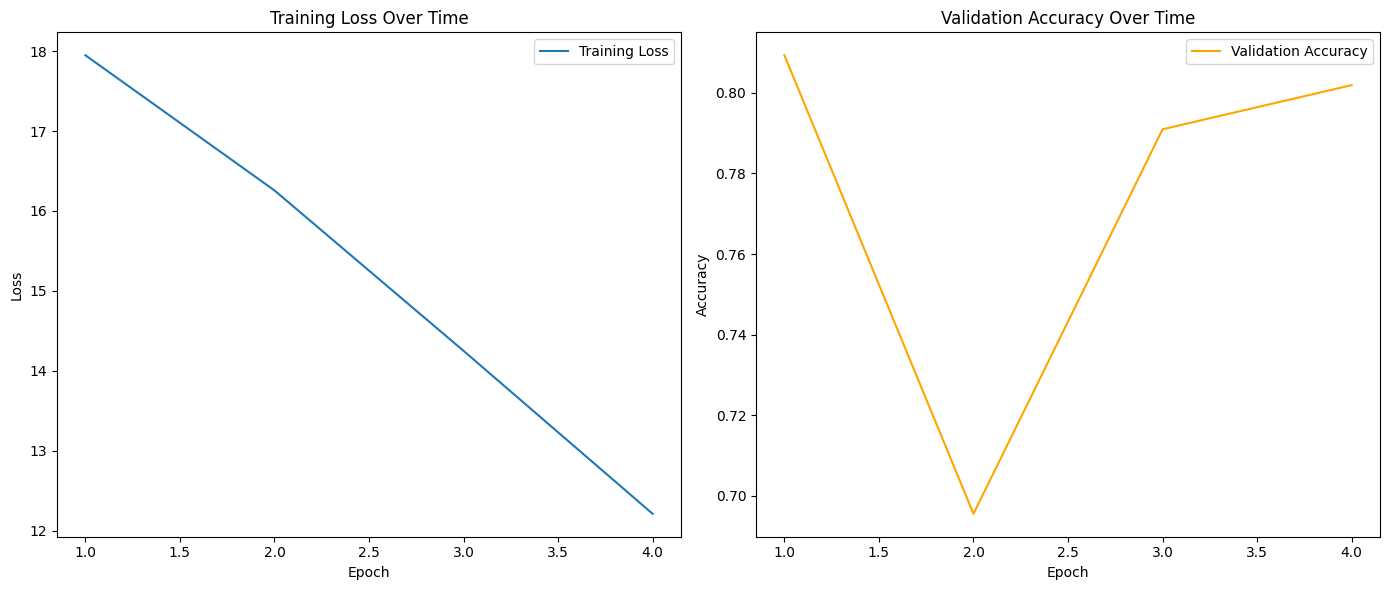

In [ ]:
import matplotlib.pyplot as plt
num_epochs = best_num_epochs
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Average training loss
    train_losses.append(train_loss / train_steps)

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    val_accuracies.append(val_accuracy)

# After training is done, plot the training loss and validation accuracy
plt.figure(figsize=(14, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs.data, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

# Convert one-hot encoded labels to class indices
# val_labels_class_indices = np.argmax(val_labels, axis=1)

# Calculate and print validation accuracy
# val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
ll_no_county_test_accuracy = np.sum(np.array(test_labels) == np.array(test_preds)) / len(test_preds)
print(f"Validation Accuracy: {ll_no_county_test_accuracy:.4f}")

100%|██████████| 97/97 [00:00<00:00, 1374.90it/s]

Validation Accuracy: 0.8135


Remove date in Long/Lat model

In [ ]:
data = pd.read_csv("data_412.csv")
#data.head()

data['county'], mapping_index = pd.factorize(data['county'])
data['region'], mapping_index = pd.factorize(data['region'])
data['tranlevel'], mapping_index = pd.factorize(data['tranlevel'])
data['tranlevel_in_2_weeks'], mapping_index = pd.factorize(data['tranlevel_in_2_weeks'])
#data = data[['cases', 'county', 'date_number', 'Population', 'region', 'pop_dens', 'crime_per_100k', 'tranlevel','tranlevel_in_2_weeks']]
data = data[['cases', 'county', 'pop_dens', 'Latitude', 'Longitude', 'tranlevel_in_2_weeks']]
data.head()

,cases,county,pop_dens,Latitude,Longitude,tranlevel_in_2_weeks
0,19035,0,404.8,36.043710,-79.399425,0
1,3908,1,107.1,34.840885,-79.480429,1
2,25979,2,1133.7,36.036030,-78.876593,0
3,18087,3,410.4,35.611178,-82.530107,0
4,8160,4,62.4,34.991536,-78.371391,0


In [ ]:
X = data.iloc[:, :-1]  # all columns except the last one
y = data.iloc[:, -1]

# Split the data into training and temporary datasets (60% training, 40% for temp).
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split the temporary datasets into validation and test datasets (50% validation, 50% test of the temp data).
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# convert dataframe to numpy array
X_train_np = X_train.to_numpy(dtype=np.float32)
y_train_np = y_train.to_numpy(dtype=np.int64)

X_valid_np = X_val.to_numpy(dtype=np.float32)
y_valid_np = y_val.to_numpy(dtype=np.int64)

X_test_np = X_test.to_numpy(dtype=np.float32)
y_test_np = y_test.to_numpy(dtype=np.int64)

# convert numpy array to PyTorch Tensor
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)

X_valid_tensor = torch.from_numpy(X_valid_np)
y_valid_tensor = torch.from_numpy(y_valid_np)

X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np)

# create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create DataLoaders
batch_size = 32 # 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = 0.2 # before hyperparameter tuning

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
# Define a list of dropout rates to explore
dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

# Initialize variables to keep track of the best dropout rate and its performance
best_dropout_rate = None
best_accuracy = 0.0

for dropout_rate in dropout_rates:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current dropout rate
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())  # Labels are still one-hot encoded here
            val_preds.extend(predicted.cpu().numpy())


    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this dropout rate resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_dropout_rate = dropout_rate

# Print the best dropout rate
print("Best Dropout Rate:", best_dropout_rate)

Best Dropout Rate: 0.8


In [ ]:
# define Neural Network Architecture

class ResNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob):
        super(ResNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = out + x
        out = self.fc3(out)
        #out = self.dropout(out)
        return out

input_size = X_train.shape[1]  # number of features
hidden_size = 32 # before hyperparamer tuning
num_classes = num_classes = len(y_train.unique())  # number of output classes
dropout_prob = best_dropout_rate # before hyperparameter tuning

model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
# model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() # because mapped values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam

In [ ]:
# epochs_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Initialize variables to keep track of the best number of epochs and its performance
best_num_epochs = None
best_accuracy = 0.0

for num_epochs in epochs_list:
    # Create DataLoaders with a fixed batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Define and train the model with the current number of epochs
    model = ResNeuralNet(input_size, hidden_size, num_classes, dropout_prob)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use Adam since NLP
    criterion = nn.CrossEntropyLoss()

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)

    # Check if this number of epochs resulted in better performance
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_num_epochs = num_epochs

# Print the best number of epochs
print("Best Number of Epochs:", best_num_epochs)

Best Number of Epochs: 4


In [ ]:
num_epochs = best_num_epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # loss = criterion(outputs, labels.float())
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Print average training loss per batch
    print(f"Average Training Loss: {train_loss / train_steps:.4f}")

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # _, predicted = torch.max(outputs.data, 1)
            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Convert one-hot encoded labels to class indices
    # val_labels_class_indices = np.argmax(val_labels, axis=1)

    # Convert to NumPy arrays
    val_preds_np = np.array(val_preds)

    # Calculate and print validation accuracy
    # val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Predicted value: {np.array(val_preds)}")
    print(f"Actual value: {np.array(val_labels)}")

Epoch 1/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 461.59it/s]


Average Training Loss: 78.5689


Epoch 1/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1569.93it/s]


Validation Accuracy: 0.7510
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 2/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 451.15it/s]


Average Training Loss: 30.2151


Epoch 2/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1599.34it/s]


Validation Accuracy: 0.7268
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 3/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 423.99it/s]


Average Training Loss: 18.0692


Epoch 3/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1561.34it/s]


Validation Accuracy: 0.7639
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 4/4 - Training: 100%|██████████| 291/291 [00:00<00:00, 398.19it/s]


Average Training Loss: 12.1567


Epoch 4/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1700.75it/s]

Validation Accuracy: 0.7997
Predicted value: [2 2 2 ... 2 2 2]
Actual value: [2 1 2 ... 2 2 2]


Epoch 4/4 - Validation: 100%|██████████| 97/97 [00:00<00:00, 1674.85it/s]


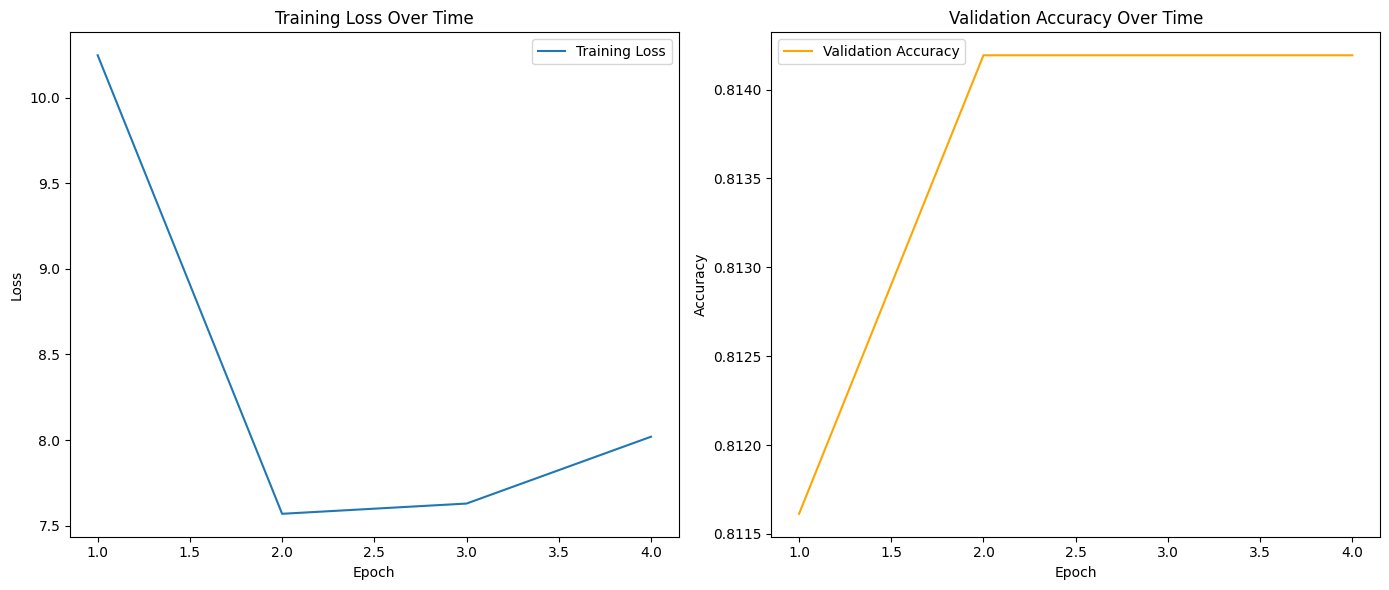

In [ ]:
num_epochs = best_num_epochs
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_steps = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_steps += 1

    # Average training loss
    train_losses.append(train_loss / train_steps)

    # Validation phase
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            predicted = torch.argmax(outputs.data, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(predicted.cpu().numpy())

    # Validation accuracy
    val_accuracy = np.sum(np.array(val_labels) == np.array(val_preds)) / len(val_preds)
    val_accuracies.append(val_accuracy)

# After training is done, plot the training loss and validation accuracy
plt.figure(figsize=(14, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs.data, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

# Convert one-hot encoded labels to class indices
# val_labels_class_indices = np.argmax(val_labels, axis=1)

# Calculate and print validation accuracy
# val_accuracy = np.sum(val_labels_class_indices == val_preds_np) / len(val_labels_class_indices)
ll_nodate_test_accuracy = np.sum(np.array(test_labels) == np.array(test_preds)) / len(test_preds)
print(f"Validation Accuracy: {ll_nodate_test_accuracy:.4f}")

100%|██████████| 97/97 [00:00<00:00, 1232.82it/s]

Validation Accuracy: 0.8329


In [ ]:
# different models with validation accuracies

data = {
    'Model': ['Original Model', 'Long/Lat Model', 'No Date Original Model', 'No County Original Model', 'No Date Long/Lat Model', 'No County Long/Lat Model', 'Just Cases Model'],
    'Test Accuracy': [og_mod_test_accuracy, ll_test_accuracy, og_no_date_test_accuracy, og_no_county_test_accuracy, ll_nodate_test_accuracy, ll_no_county_test_accuracy, cases_accuracy]
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df)


                      Model  Test Accuracy
0            Original Model       0.778065
1            Long/Lat Model       0.830000
2    No Date Original Model       0.832903
3  No County Original Model       0.832903
4    No Date Long/Lat Model       0.832903
5  No County Long/Lat Model       0.813548
6          Just Cases Model       0.832903
